# Llama3 Model Implementation from Scratch
In this notebook, I implement the Llama3 language model from scratch, one tensor and matrix multiplication operation at a time.

I will load the model parameters directly from the pre-trained weights file provided by Meta for the Llama3 model. Before running this notebook, you need to download the weights file from the official link: https://llama.meta.com/llama-downloads/

## Tokenizer

I will use the tokenizer provided by Meta for the Llama3 model.

In [1]:
from pathlib import Path
import tiktoken
from tiktoken.load import load_tiktoken_bpe
import torch
import json
import matplotlib.pyplot as plt

tokenizer_path = "Meta-Llama-3-8B/tokenizer.model"
special_tokens = [
            "<|begin_of_text|>",
            "<|end_of_text|>",
            "<|reserved_special_token_0|>",
            "<|reserved_special_token_1|>",
            "<|reserved_special_token_2|>",
            "<|reserved_special_token_3|>",
            "<|start_header_id|>",
            "<|end_header_id|>",
            "<|reserved_special_token_4|>",
            "<|eot_id|>",  # end of turn
        ] + [f"<|reserved_special_token_{i}|>" for i in range(5, 256 - 5)]
mergeable_ranks = load_tiktoken_bpe(tokenizer_path)
tokenizer = tiktoken.Encoding(
    name=Path(tokenizer_path).name,
    pat_str=r"(?i:'s|'t|'re|'ve|'m|'ll|'d)|[^\r\n\p{L}\p{N}]?\p{L}+|\p{N}{1,3}| ?[^\s\p{L}\p{N}]+[\r\n]*|\s*[\r\n]+|\s+(?!\S)|\s+",
    mergeable_ranks=mergeable_ranks,
    special_tokens={token: len(mergeable_ranks) + i for i, token in enumerate(special_tokens)},
)

tokenizer.decode(tokenizer.encode("hello world!"))

'hello world!'

## Loading Model Parameters

In a typical scenario, loading a pre-trained model involves instantiating the model class and loading the weights into the corresponding variables. However, since we are implementing Llama3 from scratch, we will load the model parameters one tensor at a time directly from the pre-trained weights file.


In [2]:
model = torch.load("Meta-Llama-3-8B/consolidated.00.pth")
print(json.dumps(list(model.keys())[:20], indent=4))

[
    "tok_embeddings.weight",
    "layers.0.attention.wq.weight",
    "layers.0.attention.wk.weight",
    "layers.0.attention.wv.weight",
    "layers.0.attention.wo.weight",
    "layers.0.feed_forward.w1.weight",
    "layers.0.feed_forward.w3.weight",
    "layers.0.feed_forward.w2.weight",
    "layers.0.attention_norm.weight",
    "layers.0.ffn_norm.weight",
    "layers.1.attention.wq.weight",
    "layers.1.attention.wk.weight",
    "layers.1.attention.wv.weight",
    "layers.1.attention.wo.weight",
    "layers.1.feed_forward.w1.weight",
    "layers.1.feed_forward.w3.weight",
    "layers.1.feed_forward.w2.weight",
    "layers.1.attention_norm.weight",
    "layers.1.ffn_norm.weight",
    "layers.2.attention.wq.weight"
]


In [3]:
with open("Meta-Llama-3-8B/params.json", "r") as f:
    config = json.load(f)
config

{'dim': 4096,
 'n_layers': 32,
 'n_heads': 32,
 'n_kv_heads': 8,
 'vocab_size': 128256,
 'multiple_of': 1024,
 'ffn_dim_multiplier': 1.3,
 'norm_eps': 1e-05,
 'rope_theta': 500000.0}

## Analyzing Model Configuration

The loaded configuration dictionary provides insights into the architecture of the Llama3 model:

- The model consists of 32 transformer layers stacked on top of each other.
- Each multi-head attention block within the transformer layers utilizes 32 attention heads to compute the attention scores.
- The vocabulary size, which represents the number of unique tokens the model can handle, is set to 128256.
- Additional details like the feed-forward network dimension multiplier, normalization epsilon value, and the rope theta parameter are also specified in the configuration.

By inspecting these configuration values, we can better understand the model's capacity, complexity, and the specific architectural choices made during its design and training.

In [4]:
dim = config["dim"]
n_layers = config["n_layers"]
n_heads = config["n_heads"]
n_kv_heads = config["n_kv_heads"]
vocab_size = config["vocab_size"]
multiple_of = config["multiple_of"]
ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config["norm_eps"]
rope_theta = torch.tensor(config["rope_theta"])

## Converting Text to Tokens

In this step, we convert the input text into a sequence of tokens using the tiktoken library, which is a tokenizer developed by OpenAI. The tokenizer breaks down the text into individual tokens, which are numerical representations of the words or subword units.


In [5]:
prompt = "the answer to the ultimate question of life, the universe, and everything is "
tokens = [128000] + tokenizer.encode(prompt)
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[128000, 1820, 4320, 311, 279, 17139, 3488, 315, 2324, 11, 279, 15861, 11, 323, 4395, 374, 220]
['<|begin_of_text|>', 'the', ' answer', ' to', ' the', ' ultimate', ' question', ' of', ' life', ',', ' the', ' universe', ',', ' and', ' everything', ' is', ' ']


## Embedding Tokens

In this section, we utilize the PyTorch `nn.Embedding` module to convert our token sequence into a sequence of embeddings. Each token is mapped to a dense vector representation of length 4096, which captures the semantic and contextual information associated with that token.

The input tokens, initially a tensor of shape [17, 1], are transformed into a tensor of shape [17, 4096], where each row represents the embedding vector for the corresponding token in the sequence.

It's important to keep track of the tensor shapes throughout the process, as it aids in understanding the transformations applied to the data.


In [6]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["tok_embeddings.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([17, 4096])

## RMS Normalization

After obtaining the token embeddings, we apply RMS (Root Mean Square) normalization to the embeddings. This step normalizes the values of the embeddings, but the shape remains unchanged. The normalization is necessary to prevent numerical instabilities during the subsequent computations.

We need to include a small constant `norm_eps` to avoid accidentally dividing by zero during the normalization process. The RMS normalization formula is as follows:

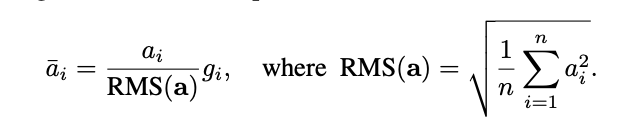


In [7]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)
def rms_norm(tensor, norm_weights):
    return (tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)) * norm_weights

## Building the Initial Transformer Layer

### Normalization
We access the first layer from the model dictionary using the key "layers.0" (this represents the initial layer).
After normalization, the tensor shape remains [17, 4096], which is the same as the embedding tensor, but with normalized values.


In [8]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["layers.0.attention_norm.weight"])
token_embeddings.shape

torch.Size([17, 4096])

### Implementing Attention from Scratch
Let's load the attention heads of the first layer of the transformer.

The query, key, value, and output vectors from the model have shapes of [4096x4096], [1024x4096], [1024x4096], and [4096x4096], respectively. At first glance, this seems odd because ideally, we want separate q, k, v, and o for each attention head.

The authors of the code bundled them together because it simplifies the implementation and helps parallelize the attention head multiplication.

In the following steps, I will unwrap these bundled vectors to obtain separate attention heads.

In [9]:
print(
    model["layers.0.attention.wq.weight"].shape,
    model["layers.0.attention.wk.weight"].shape,
    model["layers.0.attention.wv.weight"].shape,
    model["layers.0.attention.wo.weight"].shape
)

torch.Size([4096, 4096]) torch.Size([1024, 4096]) torch.Size([1024, 4096]) torch.Size([4096, 4096])


### Separating Query Vectors for Attention Heads

In the following step, we will separate the query vectors for each of the 32 attention heads in the LLaMA-3 model. The resulting shape will be [32, 128, 4096], where:

- 32 represents the number of attention heads
- 128 is the length of each query vector
- 4096 is the dimensionality of the token embeddings

In [10]:
q_layer0 = model["layers.0.attention.wq.weight"]
head_dim = q_layer0.shape[0] // n_heads
q_layer0 = q_layer0.view(n_heads, head_dim, dim)
q_layer0.shape

torch.Size([32, 128, 4096])

### Extracting the Query Weight Matrix for the First Attention Head

In this step, we will focus on the first attention head of the first layer in the LLaMA-3 model. We access the query weight matrix for this specific attention head, which has a shape of [128, 4096]. The 128 represents the length of each query vector, and 4096 is the dimensionality of the token embeddings.

In [11]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([128, 4096])

### Generating Query Vectors for Each Token

In this step, we multiply the query weight matrix for the first attention head (`q_layer0_head0`) with the token embeddings. This operation generates a query vector for each token in the input sequence. The resulting tensor has a shape of [17, 128], where 17 represents the number of tokens, and 128 is the length of each query vector.

By performing this matrix multiplication, we obtain a unique query vector for every token, allowing the model to capture the relationships between tokens and their corresponding positions within the input sequence.


In [12]:
q_per_token = torch.matmul(token_embeddings, q_layer0_head0.T)
q_per_token.shape

torch.Size([17, 128])

# Positional Encoding
At this stage, we have obtained a query vector for each token in our prompt. However, these individual query vectors do not contain any information about their position within the prompt.

Consider the following prompt:
"the answer to the ultimate question of life, the universe, and everything is "

In this prompt, the word "the" appears three times. To capture the positional information, we need to generate different query vectors (each of size [1x128]) for each occurrence of "the" based on its position in the prompt. We achieve this using Rotary Positional Embedding (RoPE).

# 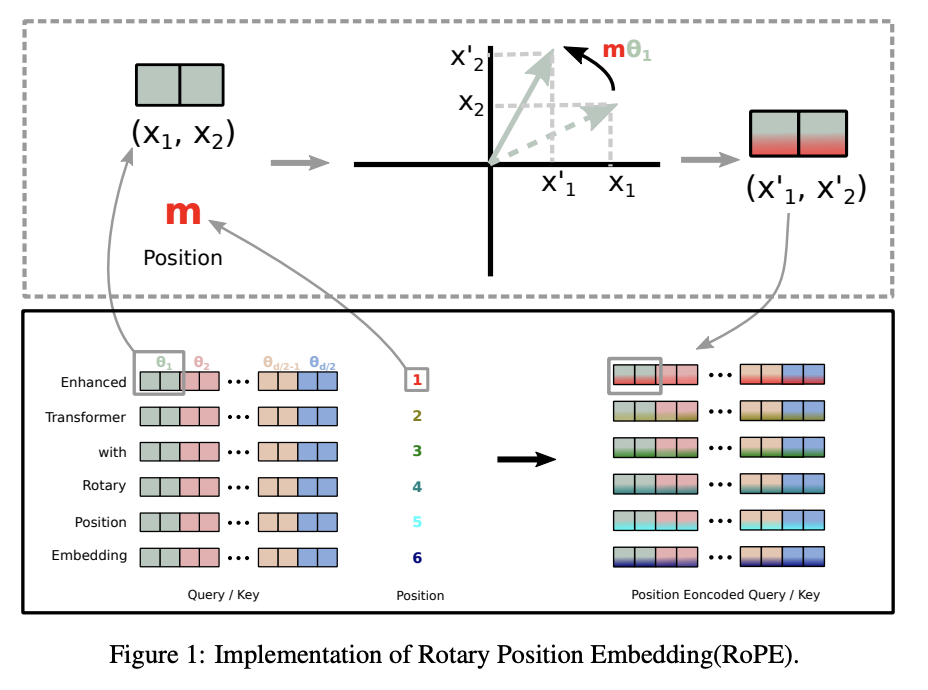

In [13]:
q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
q_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In the previous step, we divided the query vectors into pairs. Now, we will apply a rotational angle shift to each pair.

The resulting tensor has a shape of [17, 64, 2], where 17 represents the number of tokens in the prompt, 64 is the number of pairs for each token's query vector, and 2 corresponds to the real and imaginary components of each pair.

Each of these 64 pairs will be rotated by an angle proportional to the position of the token in the prompt. Specifically, the angle of rotation for a given pair is calculated as m * (theta), where m is the position of the token, and theta is a hyperparameter that controls the rate of rotation.

## Using dot product of complex numbers to rotate a vector

In [14]:
zero_to_one_split_into_64_parts = torch.tensor(range(64))/64
zero_to_one_split_into_64_parts

tensor([0.0000, 0.0156, 0.0312, 0.0469, 0.0625, 0.0781, 0.0938, 0.1094, 0.1250,
        0.1406, 0.1562, 0.1719, 0.1875, 0.2031, 0.2188, 0.2344, 0.2500, 0.2656,
        0.2812, 0.2969, 0.3125, 0.3281, 0.3438, 0.3594, 0.3750, 0.3906, 0.4062,
        0.4219, 0.4375, 0.4531, 0.4688, 0.4844, 0.5000, 0.5156, 0.5312, 0.5469,
        0.5625, 0.5781, 0.5938, 0.6094, 0.6250, 0.6406, 0.6562, 0.6719, 0.6875,
        0.7031, 0.7188, 0.7344, 0.7500, 0.7656, 0.7812, 0.7969, 0.8125, 0.8281,
        0.8438, 0.8594, 0.8750, 0.8906, 0.9062, 0.9219, 0.9375, 0.9531, 0.9688,
        0.9844])

In [15]:
freqs = 1.0 / (rope_theta ** zero_to_one_split_into_64_parts)
freqs

tensor([1.0000e+00, 8.1462e-01, 6.6360e-01, 5.4058e-01, 4.4037e-01, 3.5873e-01,
        2.9223e-01, 2.3805e-01, 1.9392e-01, 1.5797e-01, 1.2869e-01, 1.0483e-01,
        8.5397e-02, 6.9566e-02, 5.6670e-02, 4.6164e-02, 3.7606e-02, 3.0635e-02,
        2.4955e-02, 2.0329e-02, 1.6560e-02, 1.3490e-02, 1.0990e-02, 8.9523e-03,
        7.2927e-03, 5.9407e-03, 4.8394e-03, 3.9423e-03, 3.2114e-03, 2.6161e-03,
        2.1311e-03, 1.7360e-03, 1.4142e-03, 1.1520e-03, 9.3847e-04, 7.6450e-04,
        6.2277e-04, 5.0732e-04, 4.1327e-04, 3.3666e-04, 2.7425e-04, 2.2341e-04,
        1.8199e-04, 1.4825e-04, 1.2077e-04, 9.8381e-05, 8.0143e-05, 6.5286e-05,
        5.3183e-05, 4.3324e-05, 3.5292e-05, 2.8750e-05, 2.3420e-05, 1.9078e-05,
        1.5542e-05, 1.2660e-05, 1.0313e-05, 8.4015e-06, 6.8440e-06, 5.5752e-06,
        4.5417e-06, 3.6997e-06, 3.0139e-06, 2.4551e-06])

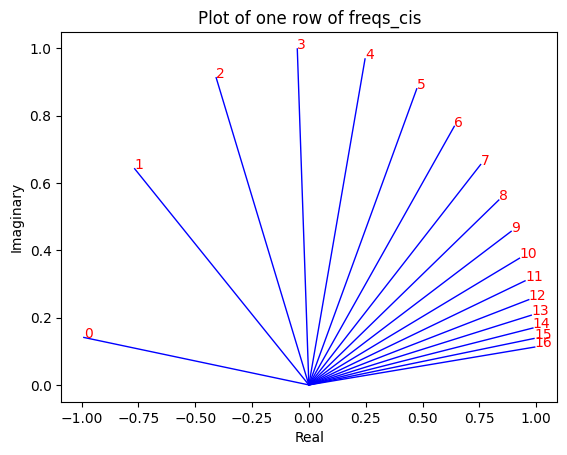

In [16]:
freqs_for_each_token = torch.outer(torch.arange(17), freqs)
freqs_cis = torch.polar(torch.ones_like(freqs_for_each_token), freqs_for_each_token)
freqs_cis.shape

# viewing tjhe third row of freqs_cis
value = freqs_cis[3]
plt.figure()
for i, element in enumerate(value[:17]):
    plt.plot([0, element.real], [0, element.imag], color='blue', linewidth=1, label=f"Index: {i}")
    plt.annotate(f"{i}", xy=(element.real, element.imag), color='red')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.title('Plot of one row of freqs_cis')
plt.show()

With the angle change vector computed for each token's query element, we can now represent the queries as complex numbers and perform a dot product with the angle change vector. This will rotate the query vector based on the token's position, effectively incorporating positional information into the query.

This approach is quite elegant and beautiful in its simplicity.

In [17]:
q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
q_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [18]:
q_per_token_as_complex_numbers_rotated = q_per_token_as_complex_numbers * freqs_cis
q_per_token_as_complex_numbers_rotated.shape

torch.Size([17, 64])

### After rotated vector is obtained
we can get back our the queries as pairs by viewing the complex numbers as real numbers again

In [19]:
q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers_rotated)
q_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

the rotated pairs are now merged, we now have a new query vector (rotated query vector) that is of the shape [17x128] where 17 is the number of tokens and the 128 is the dim of the query vector

In [20]:
q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
q_per_token_rotated.shape

torch.Size([17, 128])

## Generating Key Vectors

The process for generating key vectors is similar to that of query vectors, with a few key differences:

- Key vectors also have a dimension of 128, like the query vectors.
- However, the number of weights used to generate keys is one-fourth of the number used for queries. This is because the weights for keys are shared across four heads at a time, reducing the computational requirements.
- Just like queries, the key vectors are also rotated to incorporate positional information, using the same approach of complex number multiplication with the frequency-based angle change vector.

By following a similar process as queries, we can generate the rotated key vectors for each token, which will be used in the attention mechanism along with the rotated query vectors.

In [21]:
k_layer0 = model["layers.0.attention.wk.weight"]
k_layer0 = k_layer0.view(n_kv_heads, k_layer0.shape[0] // n_kv_heads, dim)
k_layer0.shape

torch.Size([8, 128, 4096])

In [22]:
k_layer0_head0 = k_layer0[0]
k_layer0_head0.shape

torch.Size([128, 4096])

In [23]:
k_per_token = torch.matmul(token_embeddings, k_layer0_head0.T)
k_per_token.shape

torch.Size([17, 128])

In [24]:
k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
k_per_token_split_into_pairs.shape

torch.Size([17, 64, 2])

In [25]:
k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
k_per_token_as_complex_numbers.shape

torch.Size([17, 64])

In [26]:
k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
k_per_token_split_into_pairs_rotated.shape

torch.Size([17, 64, 2])

In [27]:
k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
k_per_token_rotated.shape

torch.Size([17, 128])

At this point, we have obtained the rotated query and key vectors for each token in the input sequence.
The shape of these rotated query and key vectors is [17, 128], where 17 represents the number of tokens, and 128 is the dimension of the query/key vectors.

## Next, we will compute the dot product between the query and key matrices
This operation yields a score that quantifies the relevance between each token pair

In other words, it measures how well each token's query aligns with every other token's key
THIS PROCESS IS KNOWN AS SELF-ATTENTION

The resulting attention score matrix (qk_per_token) has a shape of [17, 17], where 17 represents the number of tokens in the input prompt


In [28]:
qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(head_dim)**0.5
qk_per_token.shape

torch.Size([17, 17])

## Masking Future Token Scores

In the training process of LLaMA-3, the query-key scores for future tokens are masked. This is because the model learns to predict tokens based solely on the past tokens, not the future ones.

During inference, we set the scores for future tokens to zero to maintain this constraint. By masking the future token scores, we ensure that the model's predictions are based only on the preceding context, aligning with the training objective.

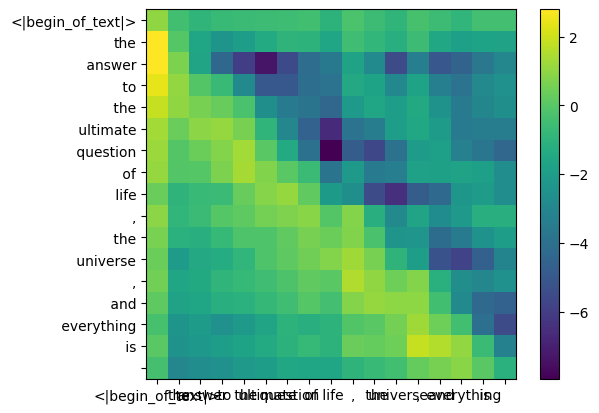

In [29]:
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [30]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -in

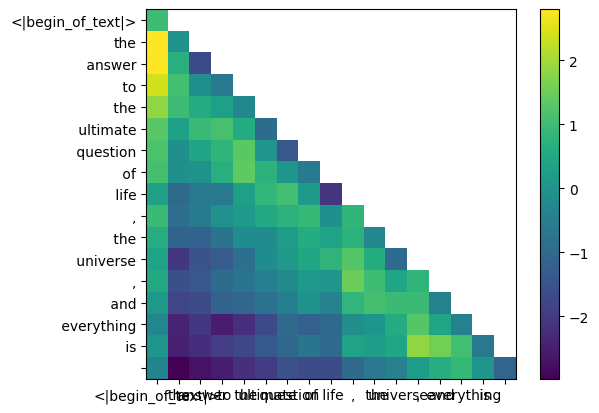

In [31]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

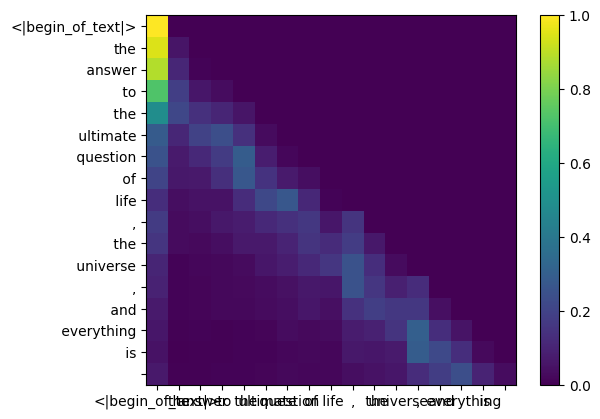

In [32]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

## Value Vectors: The Final Step in Attention

The attention scores (ranging from 0 to 1) determine how much each value vector contributes to the final attention output for a given token.

Similar to the key vectors, the value weight matrix is shared across every 4 attention heads to reduce computational overhead.

Consequently, the shape of the value weight matrix is [8, 128, 4096], where 8 represents the number of groups of 4 attention heads, 128 is the dimension of the value vector per token, and 4096 is the model's overall dimension.


In [33]:
v_layer0 = model["layers.0.attention.wv.weight"]
v_layer0 = v_layer0.view(n_kv_heads, v_layer0.shape[0] // n_kv_heads, dim)
v_layer0.shape

torch.Size([8, 128, 4096])

the first layer, first head value weight matrix is given below

In [34]:
v_layer0_head0 = v_layer0[0]
v_layer0_head0.shape

torch.Size([128, 4096])

## Calculating Value Vectors

We now compute the value vectors for each token by multiplying the token embeddings with the value weight matrix. The resulting value vectors have a shape of [17, 128], where 17 represents the number of tokens in the prompt, and 128 is the dimensionality of the value vector for each token.

In [35]:
v_per_token = torch.matmul(token_embeddings, v_layer0_head0.T)
v_per_token.shape

torch.Size([17, 128])

## Attention

The resultant attention vector after multipying with the values per token is of shape [17*128]

In [36]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([17, 128])

## Multi-Head Attention

We have calculated the attention value for the first layer and the first head. Now, we will iterate over all heads in the first layer and perform the same computations as the previous cells to obtain the attention values for each head.

In [37]:
qkv_attention_store = []

for head in range(n_heads):
    q_layer0_head = q_layer0[head]
    k_layer0_head = k_layer0[head//4] # key weights are shared across 4 heads
    v_layer0_head = v_layer0[head//4] # value weights are shared across 4 heads
    q_per_token = torch.matmul(token_embeddings, q_layer0_head.T)
    k_per_token = torch.matmul(token_embeddings, k_layer0_head.T)
    v_per_token = torch.matmul(token_embeddings, v_layer0_head.T)

    q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
    q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
    q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)

    k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
    k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
    k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis[:len(tokens)])
    k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)

    qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    qkv_attention_store.append(qkv_attention)

len(qkv_attention_store)

32

We now have a the qkv_attention matrix for all 32 heads on the first layer, next im going to merge all attention scores into one large matrix of size [17x4096]

In [38]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([17, 4096])

## Weight Matrix

After calculating the attention scores for all heads in the first layer, we need to apply a weight matrix to the combined attention output. This weight matrix is a learnable parameter that helps the model focus on the most relevant parts of the input. Multiplying the attention output with this weight matrix is one of the final steps in the attention mechanism for layer 0.

In [39]:
w_layer0 = model["layers.0.attention.wo.weight"]
w_layer0.shape

torch.Size([4096, 4096])

### this is a simple linear layer, so we just matmul

In [40]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([17, 4096])

We now have the change in the embedding value after attention, that should be adding to the original token embeddings

In [41]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([17, 4096])

We normalize and then run a feed forward neural network through the embedding delta

In [42]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["layers.0.ffn_norm.weight"])
embedding_after_edit_normalized.shape

torch.Size([17, 4096])

## Implementing the Feed Forward Network

In the LLaMA-3 model, a SwiGLU (Swish-Gated Linear Unit) feed forward network is used. This network architecture is effective at introducing non-linearity when required by the model, which is a common practice in large language models.

The SwiGLU feed forward network allows the model to learn complex, non-linear transformations on the input embeddings, enabling it to capture intricate patterns and relationships in the data.

In [43]:
w1 = model["layers.0.feed_forward.w1.weight"]
w2 = model["layers.0.feed_forward.w2.weight"]
w3 = model["layers.0.feed_forward.w3.weight"]
output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([17, 4096])

We now have the updated token embeddings after processing through the first layer of the model. This means the embeddings have been modified to incorporate information from the attention mechanism and feed-forward network of the initial layer.

While this is a significant step, there are still 31 more layers to go through before we have the final output embeddings. The remaining layers will be processed in a loop.

These updated embeddings can be thought of as encoding the initial set of queries or relationships between tokens, based on the attention patterns learned in the first layer. With each subsequent layer, the model will capture increasingly complex interactions and dependencies, building up a rich representation that ultimately allows it to predict the next token accurately.

In [44]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([17, 4096])

The core loop iterates over each layer, updating the embeddings through attention and feed-forward networks. First, the input embeddings are normalized. Then, the attention mechanism computes attention scores between queries and keys, applies masking, and obtains attention weights. Finally, the embeddings are updated using the attention-weighted values and processed through a feed-forward network.

In [45]:
final_embedding = token_embeddings_unnormalized
for layer in range(n_layers):
    qkv_attention_store = []
    layer_embedding_norm = rms_norm(final_embedding, model[f"layers.{layer}.attention_norm.weight"])
    q_layer = model[f"layers.{layer}.attention.wq.weight"]
    q_layer = q_layer.view(n_heads, q_layer.shape[0] // n_heads, dim)
    k_layer = model[f"layers.{layer}.attention.wk.weight"]
    k_layer = k_layer.view(n_kv_heads, k_layer.shape[0] // n_kv_heads, dim)
    v_layer = model[f"layers.{layer}.attention.wv.weight"]
    v_layer = v_layer.view(n_kv_heads, v_layer.shape[0] // n_kv_heads, dim)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        k_layer_head = k_layer[head//4]
        v_layer_head = v_layer[head//4]
        q_per_token = torch.matmul(layer_embedding_norm, q_layer_head.T)
        k_per_token = torch.matmul(layer_embedding_norm, k_layer_head.T)
        v_per_token = torch.matmul(layer_embedding_norm, v_layer_head.T)
        q_per_token_split_into_pairs = q_per_token.float().view(q_per_token.shape[0], -1, 2)
        q_per_token_as_complex_numbers = torch.view_as_complex(q_per_token_split_into_pairs)
        q_per_token_split_into_pairs_rotated = torch.view_as_real(q_per_token_as_complex_numbers * freqs_cis)
        q_per_token_rotated = q_per_token_split_into_pairs_rotated.view(q_per_token.shape)
        k_per_token_split_into_pairs = k_per_token.float().view(k_per_token.shape[0], -1, 2)
        k_per_token_as_complex_numbers = torch.view_as_complex(k_per_token_split_into_pairs)
        k_per_token_split_into_pairs_rotated = torch.view_as_real(k_per_token_as_complex_numbers * freqs_cis)
        k_per_token_rotated = k_per_token_split_into_pairs_rotated.view(k_per_token.shape)
        qk_per_token = torch.matmul(q_per_token_rotated, k_per_token_rotated.T)/(128)**0.5
        mask = torch.full((len(token_embeddings_unnormalized), len(token_embeddings_unnormalized)), float("-inf"))
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1).to(torch.bfloat16)
        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        qkv_attention_store.append(qkv_attention)

    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"layers.{layer}.attention.wo.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"layers.{layer}.ffn_norm.weight"])
    w1 = model[f"layers.{layer}.feed_forward.w1.weight"]
    w2 = model[f"layers.{layer}.feed_forward.w2.weight"]
    w3 = model[f"layers.{layer}.feed_forward.w3.weight"]
    output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
    final_embedding = embedding_after_edit+output_after_feedforward

At this point, we have obtained the final embedding, which represents the model's best prediction for the next token. This embedding has the same shape as the regular token embeddings, [17, 4096], where 17 is the number of tokens, and 4096 is the embedding dimension.


In [46]:
final_embedding = rms_norm(final_embedding, model["norm.weight"])
final_embedding.shape

torch.Size([17, 4096])

## Decoding the Final Embedding

Now that we have obtained the final embedding, which represents the model's prediction for the next token, we need to decode this embedding into the actual token value. To accomplish this, we will utilize the output decoder layer of the model.

In [47]:
model["output.weight"].shape

torch.Size([128256, 4096])

## Predicting the Next Token

We will utilize the final embedding, which represents the model's prediction for the next token, to decode and obtain the actual token value. Specifically, we will use the embedding of the last token in the sequence.

In this case, we are hoping that the predicted token will be "42". This value holds significance as it is the "answer to the ultimate question of life, the universe, and everything" according to the famous novel "The Hitchhiker's Guide to the Galaxy" by Douglas Adams. Most modern language models would likely output "42" in response to this prompt, which would serve as a validation of our implementation. Let's see if our code can achieve this!

In [48]:
logits = torch.matmul(final_embedding[-1], model["output.weight"].T)
logits.shape

torch.Size([128256])

In [49]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(2983)

The model predicted token number 2983 as the next token which is "42".

In [50]:
tokenizer.decode([next_token.item()])

'42'